In [1]:
import json
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot: title={'center': 'Positioning'}, xlabel='timestamp', ylabel='volatility_exposure'>

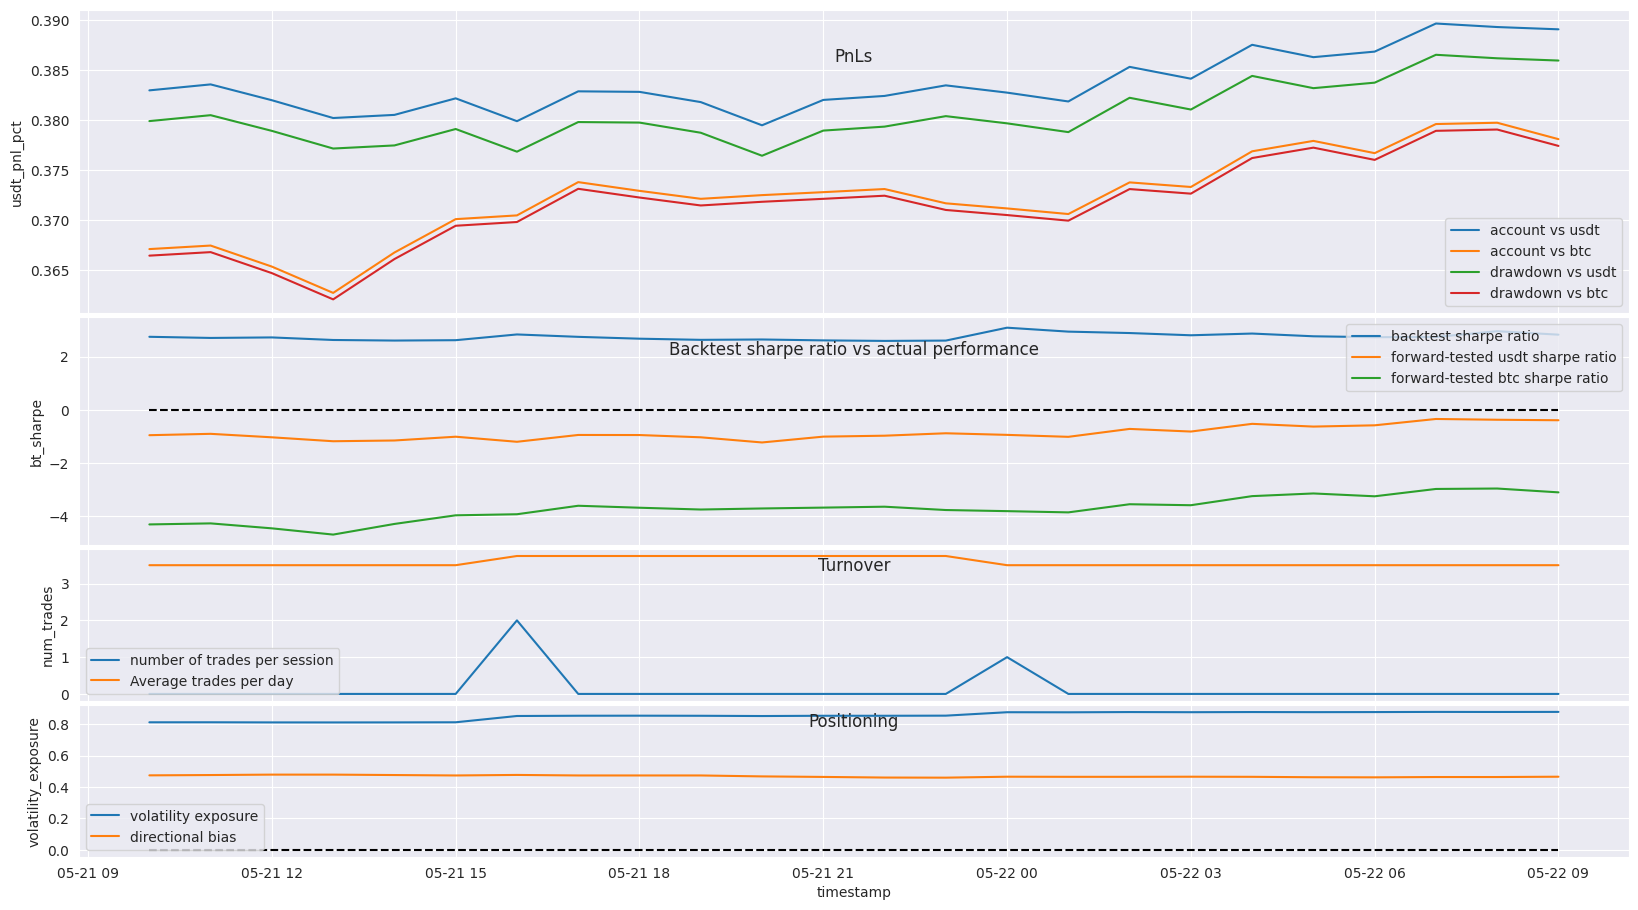

In [34]:
# TODO i want drawdown statistics like max dd, avg dd, max dd duration and avg dd duration and current dd duration - for the backtest and the live trading so i can compare

with open(Path("/home/ross/coding/pi_3/modular_trader/continuous/records/session.json"), 'r') as file:
    session_records = json.load(file)

for s in session_records:
    if s.get('volatility_exposure') is None:
        s['volatility_exposure'] = 0.0
    elif s.get('volatility_exposure') > 10:
        s['volatility_exposure'] = 0.9349222790015471

session_records_2 = [s for s in session_records if s.get('bt_sharpe')]
session_records_3 = [s for s in session_records if s.get('volatility_exposure')]

sr = pl.from_dicts(session_records).select(['timestamp', 'usdt_net', 'btc_net', 'trades'])
sr_2 = pl.from_dicts(session_records_2)['bt_sharpe']
sr_3 = pl.from_dicts(session_records_3)['volatility_exposure']
allos = [s[f"{s.get('port_weights', 'flat')}_allocations"] for s in session_records]
bias = pl.Series([sum(z.values()) for z in allos])
pred_exp = pl.Series([sum([abs(v) for v in z.values()]) for z in allos]) * 2

sr_2 = pl.Series([0.0] * (len(sr) - len(sr_2))).extend(sr_2)
sr_3 = pl.Series([0.0] * (len(sr) - len(sr_3))).extend(sr_3)

sharpe_lb = 720 # 168 = 1 week, 720 = 30 days, 2190 = 1Q, 8760 = 1 year
sr = sr.with_columns(
    pl.col('timestamp').mul(1000).cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms')),
    pl.col('usdt_net').truediv(sr.item(0, 'usdt_net')).alias('usdt_pnl_pct'),
    pl.col('btc_net').truediv(sr.item(0, 'btc_net')).alias('btc_pnl_pct'),
    pl.col('usdt_net').pct_change().ewm_mean(span=sharpe_lb, min_periods=48).mul(8760).truediv(pl.col('usdt_net').pct_change().ewm_std(span=sharpe_lb, min_periods=48).mul(92)).alias('usdt_sharpe'),
    pl.col('btc_net').pct_change().ewm_mean(span=sharpe_lb, min_periods=48).mul(8760).truediv(pl.col('btc_net').pct_change().ewm_std(span=sharpe_lb, min_periods=48).mul(92)).alias('btc_sharpe'),
    pl.lit(1.0).sub(pl.col('usdt_net').rolling_max(window_size=100_000, min_periods=1).sub(pl.col('usdt_net')).truediv(pl.col('usdt_net').rolling_max(window_size=100_000, min_periods=1))).alias('usdt_dd'),
    pl.lit(1.0).sub(pl.col('btc_net').rolling_max(window_size=100_000, min_periods=1).sub(pl.col('btc_net')).truediv(pl.col('btc_net').rolling_max(window_size=100_000, min_periods=1))).alias('btc_dd'),
    pl.col('trades').alias('num_trades'),
    pl.col('trades').rolling_sum(96).truediv(4).alias('avg_trades'),
    sr_2.alias('bt_sharpe'),
    sr_3.alias('volatility_exposure'),
    bias.alias('bias'),
    # pred_exp.alias('pred_exp')
).tail(24)

fig, ax = plt.subplots(nrows=4, figsize=(20, 11), gridspec_kw=dict(height_ratios=[4, 3, 2, 2]), sharex=True)
fig.subplots_adjust(hspace = 0.02)
ax[0].set_title('PnLs', y=0.8)
ax[1].set_title('Backtest sharpe ratio vs actual performance', y=0.8)
ax[2].set_title('Turnover', y=0.8)
ax[3].set_title('Positioning', y=0.8)

sns.lineplot(data=sr, x='timestamp', y='usdt_pnl_pct', label='account vs usdt', ax=ax[0])
sns.lineplot(data=sr, x='timestamp', y='btc_pnl_pct', label='account vs btc', ax=ax[0])
sns.lineplot(data=sr, x='timestamp', y='usdt_dd', label='drawdown vs usdt', ax=ax[0])
sns.lineplot(data=sr, x='timestamp', y='btc_dd', label='drawdown vs btc', ax=ax[0])

sns.lineplot(data=sr, x='timestamp', y='bt_sharpe', label='backtest sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y='usdt_sharpe', label='forward-tested usdt sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y='btc_sharpe', label='forward-tested btc sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y=0, color='black', linestyle='--', ax=ax[1])

sns.lineplot(data=sr, x='timestamp', y='num_trades', label='number of trades per session', ax=ax[2])
sns.lineplot(data=sr, x='timestamp', y='avg_trades', label='Average trades per day', ax=ax[2])

sns.lineplot(data=sr, x='timestamp', y='volatility_exposure', label='volatility exposure', ax=ax[3])
sns.lineplot(data=sr, x='timestamp', y='bias', label='directional bias', ax=ax[3])
# sns.lineplot(data=sr, x='timestamp', y='pred_exp', label='predicted exposure', ax=ax[3])
sns.lineplot(data=sr, x='timestamp', y=0, color='black', linestyle='--', ax=ax[3])

# statistics


In [49]:
[s.get('volatility_exposure', 0.0) for s in session_records_3]

[0.41928429650643606,
 0.4139342228245926,
 0.41849236249755606,
 0.3989708552042759,
 0.39736343526043316,
 0.3955100823144355,
 0.3960097755996943,
 0.39260045326078163,
 0.3981265354369714,
 0.40205861420024247,
 0.4070277907963844,
 0.43237668432068443,
 0.4248549242893218,
 0.42799109038445304,
 0.4260997223512182,
 0.42947564991505915,
 0.42969171360305314,
 0.42660858126649237,
 0.4173264141548707,
 0.40279858191727014,
 0.42442076982611665,
 0.4301526674890075,
 0.4333442361021471,
 0.4366350389932181,
 0.4403023890802997,
 0.43657564733022025,
 0.43724026747685607,
 0.4304798861148986,
 0.4314732455904422,
 0.4409902312410825,
 0.4681860549534933,
 0.4465588736827124,
 0.45149943898208345,
 0.45799875238766585,
 0.4572414821462518,
 0.4610796217071311,
 0.4493528275442489,
 0.4447541963784889,
 0.44525452075652794,
 0.4481612252997704,
 0.4441763340006595,
 0.44471110586945684,
 0.4438147638541572,
 0.4450216759379202,
 0.45063532375967963,
 0.4515867962505331,
 0.454533740394

In [50]:
for s in session_records:
    if s.get('volatility_exposure') is None:
        s['volatility_exposure'] = 0.0
    elif s.get('volatility_exposure') > 10:
        s['volatility_exposure'] = 0.9349222790015471